In [1]:
import fastai.vision.all as fv
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import random
from pathlib import Path
from math import prod
from fastai.vision.all import delegates


In [15]:
torch.cuda.is_available()

True

In [2]:
dir_things=Path('/notebooks/storage/exp_arq')
files_things=fv.get_image_files(dir_things)
files_things

(#18867) [Path('/notebooks/storage/exp_arq/train/dishwasher/n03207941_8443.jpg'),Path('/notebooks/storage/exp_arq/train/dishwasher/n03207941_1273.jpg'),Path('/notebooks/storage/exp_arq/train/dishwasher/n03207941_7063.jpg'),Path('/notebooks/storage/exp_arq/train/dishwasher/n03207941_16734.jpg'),Path('/notebooks/storage/exp_arq/train/dishwasher/n03207941_6728.jpg'),Path('/notebooks/storage/exp_arq/train/dishwasher/n03207941_17428.jpg'),Path('/notebooks/storage/exp_arq/train/dishwasher/n03207941_3742.jpg'),Path('/notebooks/storage/exp_arq/train/dishwasher/n03207941_3680.jpg'),Path('/notebooks/storage/exp_arq/train/dishwasher/n03207941_12600.jpg'),Path('/notebooks/storage/exp_arq/train/dishwasher/n03207941_11919.jpg')...]

In [3]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self,x):
        return x.view(x.shape[0],-1)
def num_params(model):
    return sum([prod(p.shape) for p in model.parameters()])

In [4]:
def conv2d(ni,no,k=3,s=1,pad="same",g=1,bias=True):
    """ni, no son num de canales de entrada y salida respectivamente"""
    if pad=="same": pad = (k-1)//2

    return nn.Conv2d(ni,no,kernel_size=k,stride=s,padding=pad,groups=g,bias=bias)


@delegates(conv2d)
def cab(ni, no, act_fn=nn.ReLU(), **kwargs):
    """cab se refiere a convolucion->activacion->batchnorm :)"""
    layers = []
    
    layers += [conv2d(ni, no, **kwargs)]
    layers += [act_fn]
    layers += [nn.BatchNorm2d(no)]
    
    return layers

In [77]:
class ResBlock(nn.Module):
    def __init__(self, ni, no = None, stride=1):
        super().__init__()
        self.stride = stride
        if no is None: no = ni
            
        k = 3
        if stride == 2:
            k = 4
            
        use_pool = (ni != no) or (stride != 1)
        
        self.pool = nn.Sequential(*cab(ni,no,k=k,s=stride))
        self.residual = nn.Sequential(*cab(ni,ni//2,k=k,s=stride), # juega con esto!!
                                      *cab(ni//2,no//2), 
                                      *cab(no//2, no)
                                     )
        nn.init.zeros_(self.residual[-1].weight) # juega con esto!!
        
    def forward(self, x):
        return self.pool(x) + self.residual(x)

In [78]:
def load_data(path, size, bs):
    tfms = fv.aug_transforms(size = size,
                             flip_vert=False, 
                             max_rotate=10, 
                             max_lighting=0.3, 
                             max_zoom=1.2,
                             max_warp=0.1)
    
    h,w = [int(2*t) for t in size]
    data = fv.DataBlock(blocks    = (fv.ImageBlock, fv.CategoryBlock),
                        get_items = fv.get_image_files,
                        get_y     = fv.parent_label,
                        splitter  = fv.GrandparentSplitter(),
                        item_tfms = fv.Resize((h,w)),
                        batch_tfms= tfms,
                     )
    return data.dataloaders(path, bs=bs)

In [79]:
data = load_data(dir_things,(128,192),64)

In [80]:
red_neuronal = nn.Sequential(
    nn.BatchNorm2d(3),
    conv2d(3, 32, s=2),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2),
    conv2d(32, 64),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    #ResBlock(64),
    conv2d(64, 128),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    #ResBlock(128),
    nn.MaxPool2d(2),
    conv2d(128, 256),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    #ResBlock(256),
    nn.MaxPool2d(2),
    conv2d(256, 512),
    nn.ReLU(),
    nn.BatchNorm2d(512),
    nn.AdaptiveAvgPool2d(1), 
    Flatten(),
    nn.Linear(512, 256), 
    nn.LeakyReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(256, data.c))

print(f"Num parameters: {num_params(red_neuronal)/10**6:.2f}M")

Num parameters: 1.71M


SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.00013182566908653826)

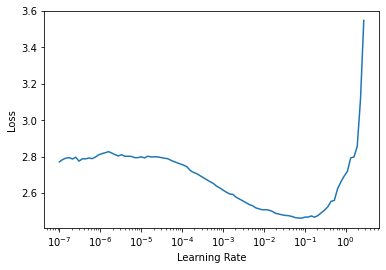

In [81]:
learn = fv.Learner(data,red_neuronal,opt_func=fv.ranger,metrics=fv.accuracy)
learn.lr_find()

In [82]:
from fastai.vision.all import *
learn.fit_one_cycle(10,7e-3,div=1.1,div_final=10000.0,pct_start=0.7)
#learn.fit_one_cycle(10,2e-3,div=1.1,pct_start=0.5,mom=1)

epoch,train_loss,valid_loss,accuracy,time
0,1.783185,1.737398,0.370000,00:20
1,1.588498,1.620591,0.400000,00:19
2,1.465284,1.657068,0.411429,00:19
3,1.389372,1.398401,0.471429,00:19
4,1.308446,1.530938,0.440000,00:19
5,1.204345,1.260221,0.515714,00:19
6,1.147173,1.372871,0.477143,00:19
7,1.046317,1.175479,0.547143,00:19
8,0.934742,1.075209,0.565714,00:19
9,0.844339,1.067762,0.564286,00:19


In [76]:
import gc
gc.collect()

92493